# `tfp_helper` : Inference and Plotting for TFP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
%load_ext autoreload
%autoreload 2

## Poisson Distribution

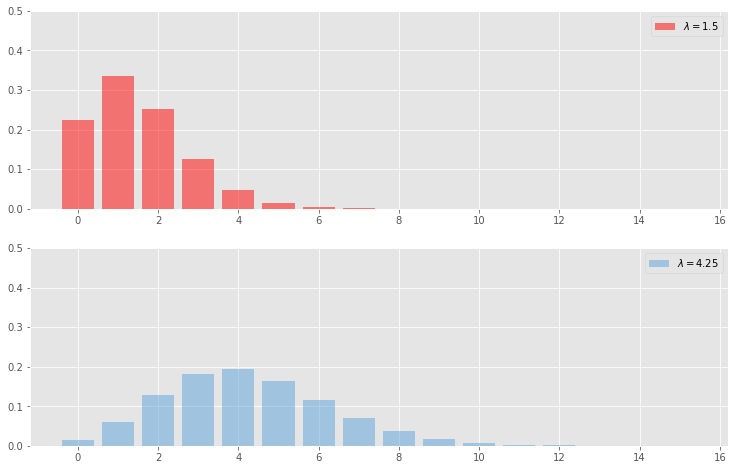

In [6]:
rate = [[1.5], [4.25]]
var_poi = tfd.Poisson(rate=rate)
poi_pmf = var_poi.prob(np.arange(0, 16))
color_blue = '#5DA5DA'
colors = ['red', color_blue]
plt.figure(figsize=(12.5, 8))
for i in range(2):
    ax = plt.subplot(2, 1, i+1)
    plt.bar(np.arange(0, 16), poi_pmf[i], color=colors[i],
            label='$\lambda={}$'.format(rate[i][0]), alpha=0.5)
    plt.ylim([0, 0.5])
    plt.legend()

## Data

In [7]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

(0.0, 74.0)

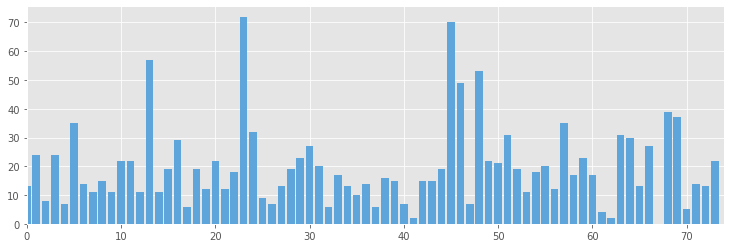

In [8]:
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color=color_blue)
plt.xlim(0, n_count_data[0].numpy())

In [9]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    alpha = (1 / tf.reduce_mean(count_data))
    var_lambda_1 = tfd.Exponential(rate=alpha)
    var_lambda_2 = tfd.Exponential(rate=alpha)
    
    var_tau = tfd.Uniform(low=0., high=1.)
    # lambda 1 vs 2 indices
    tau_scaled = tf.convert_to_tensor(tau * count_data.shape[0], dtype=tf.float32)
    indices = tf.cast(tf.range(count_data.shape[0]), tf.float32)
    lambda_ = tf.gather([lambda_1, lambda_2],
                  indices=tf.cast(tau_scaled <= indices, dtype=tf.int32))
    var_obs = tfd.Poisson(rate=lambda_)
    return (
        var_lambda_1.log_prob(lambda_1)
        + var_lambda_2.log_prob(lambda_2)
        + var_tau.log_prob(tau)
        + tf.reduce_sum(var_obs.log_prob(count_data))
    )

## Inference wrapper

In [11]:
from tfp_helper import evaluate, infer

In [12]:
infer?

In [13]:
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32),
    tf.cast(tf.reduce_mean(count_data), tf.float32),
    0.5,
]

In [14]:
azdata = infer(joint_log_prob, count_data,
              variables=['lambda_1', 'lambda_2', 'tau'],
              initial_chain_state=initial_chain_state,
              nsteps=30000,
              bijectors={
                  'lambda_1' : tfb.Exp(),
                  'lambda_2' : tfb.Exp(),
                  'tau' : tfb.Identity()
              })

In [15]:
import arviz as az

array([[<AxesSubplot:title={'center':'lambda_1'}>,
        <AxesSubplot:title={'center':'lambda_1'}>],
       [<AxesSubplot:title={'center':'lambda_2'}>,
        <AxesSubplot:title={'center':'lambda_2'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

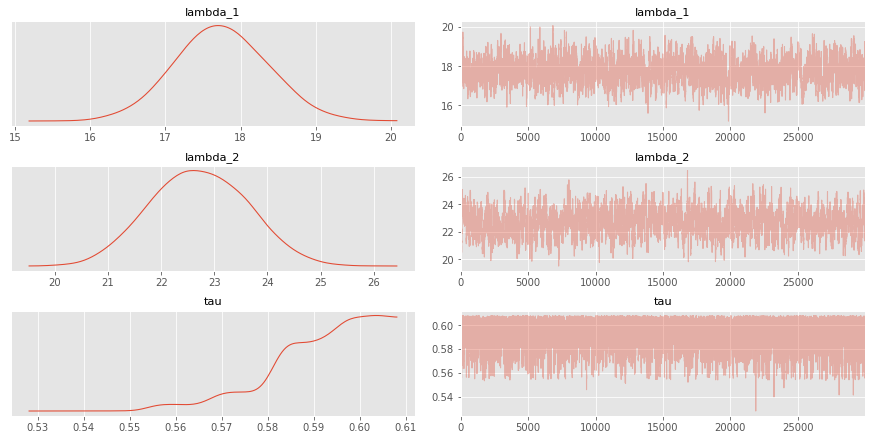

In [22]:
az.plot_trace(azdata)